### This is Assignment2 Part2 for EE214 Machine Learning Basics and Practices.
Euiseok Han, 20200690\
Date: 052125

I utilized the given skeleton code.

In [69]:
!pip install ucimlrepo #This installs the UCIML library to import the dataset

In [84]:
# ==========================================
# EE214 Assignment 2 Clustering Skeleton
# ==========================================
# Code skeleton for Task 2. You may change it as you deem necessary.

# ---------- 0. Imports ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo  # one line UCI fetch

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer # for handling missing values
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE


# For AutoEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [71]:
# ---------- 1. Data Loading ----------
derm = fetch_ucirepo(name="Dermatology")  # TODO: cache locally if slow

X_raw = derm.data.features.to_numpy()  # 34 features (no labels)
X_unknown = pd.read_csv("unknown_dataset.csv").to_numpy()  # 5452 × 10 PCA
y_true = derm.data.targets.to_numpy().astype(int).flatten()  # ground truth, will be used after step 8

#TODO: Filling missing values
# According to the official website of the dataset, some values of ages are missing.
# However, age might irrelevant to the class code.
# Also, since the number of missing values are small compare to the number of samples,
# I just filled the missing values with mean value of other samples.
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_raw)

In [72]:
# ---------- 2. Scaling ----------
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(X_filled)

minmax_scaler = MinMaxScaler()  # for comparison
X_minmax = minmax_scaler.fit_transform(X_filled)

In [73]:
# ---------- 3. Dimensionality Reduction ----------
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_std)

# Verify PCA output shape
print('PCA output shape:', X_pca.shape)

PCA output shape: (366, 22)


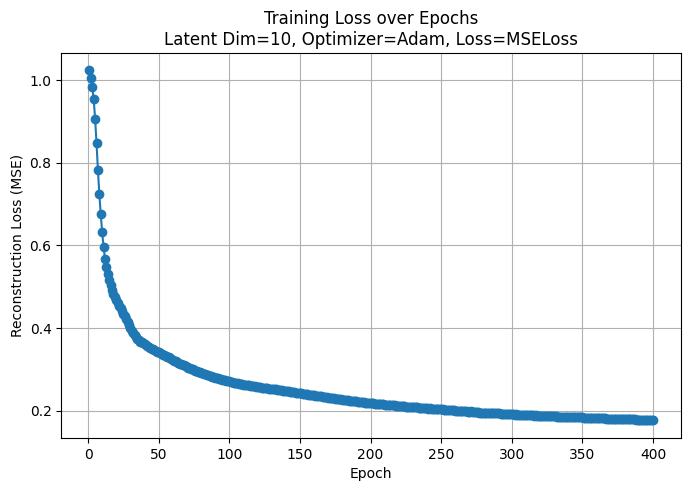

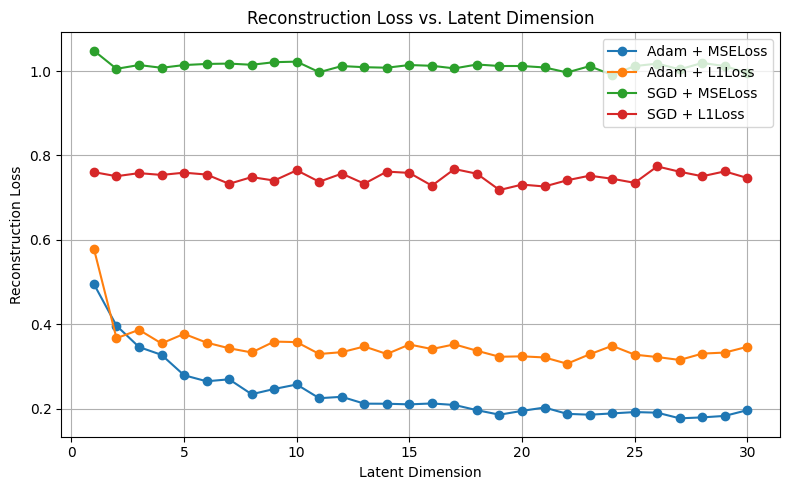

In [74]:
# ---------- AutoEncoder stub ----------
class AE(nn.Module):
    def __init__(self, in_dim, latent_dim=10):
        super().__init__()
        # TODO: define encoder / decoder layers
        # I designed encoder with input_layer(dim=34), hidden_layer(dim=16), and output_layer(dim=latent_dim)
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        # Again, I designed decoder with input_layer(dim=latent_dim), hidden_layer(dim=16), and output_layer(dim=34)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, in_dim)
        )

    # pass through a sample into the encoder following by the decoder.
    def forward(self, x):
        # TODO: forward pass
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)

        return reconstructed
    
    def encode(self, x):
        return self.encoder(x)

def train_ae(x_np, latent_dim, epochs, optimizer, criterion):
    """Returns latent representation (np.ndarray)."""
    # TODO: build model, optimizer, loss, training loop
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x_tensor = torch.tensor(x_np, dtype=torch.float32)
    dataset = TensorDataset(x_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = AE(in_dim=x_np.shape[1], latent_dim=latent_dim).to(device)
    opt = optimizer(model.parameters(), lr=1e-3)
    cri = criterion()
    epoch_losses = []

    # Train model
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in loader:
            inputs = batch[0].to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = cri(outputs, inputs)
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(loader.dataset)
        epoch_losses.append(epoch_loss)

    # 학습 후 latent representation 추출
    model.eval()
    with torch.no_grad():
        x_tensor = x_tensor.to(device)
        latent = model.encode(x_tensor).cpu().numpy()

    return latent, epoch_losses


# latent_dim = 10
# epochs = 100
# X_ae, loss = train_ae(X_std, latent_dim, epochs)
# -------------------------------------
losses_dict = {}
dims = list(range(1, 31))
optimizers = [optim.Adam, optim.SGD]
criterions = [nn.MSELoss, nn.L1Loss]

_, epoch_losses = train_ae(X_std, latent_dim=10, epochs=400, optimizer=optim.Adam, criterion=nn.MSELoss)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title(f"Training Loss over Epochs\nLatent Dim={'10'}, Optimizer={'Adam'}, Loss={'MSELoss'}")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.grid(True)
plt.show()


for optimizer in optimizers:
    for criterion in criterions:
        losses = []
        for latent_dim in dims:
            X_ae, epoch_losses = train_ae(X_std, latent_dim=latent_dim, epochs=150, optimizer=optimizer, criterion=criterion)
            losses.append(epoch_losses[-1])
            
        label = f"{optimizer.__name__} + {criterion.__name__}"
        losses_dict[label] = losses

plt.figure(figsize=(8, 5))
for label, losses in losses_dict.items():
    plt.plot(dims, losses, marker='o', label=label)

plt.title('Reconstruction Loss vs. Latent Dimension')
plt.xlabel('Latent Dimension')
plt.ylabel('Reconstruction Loss')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Experiment results show that only 150 epoch is enough to observe efficiency of the training result.\
Comparing four different combinations of optimizers and loss functions, I decided to use Adam optimizer and MSELoss function in the rest of the experiment.\
Also, by applying elbow method to the graph utilizing Adam optimizer and MSELoss function, I selected latent dimension as 10.

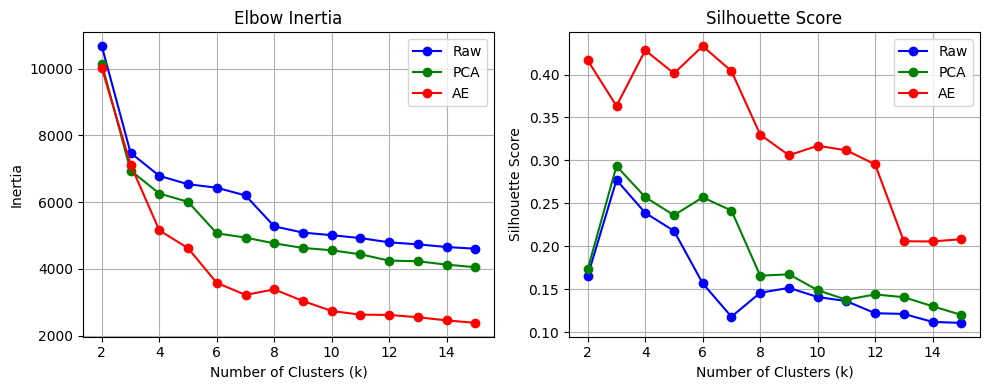

In [75]:
# ---------- 4. Helper: k-Means Elbow & Silhouette ----------
def kmeans_elbow_silhouette_calculator(X, k_range=range(2, 16)):
    inertia, sil = [], []
    for k in k_range:
        # TODO: run KMeans, get inertia and Silhouette scores
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        inertia.append(model.inertia_)
        sil.append(silhouette_score(X, labels))
    
    return inertia, sil

# From here, we calculate actual elbow inertia and silhouette score
# for three different Xs: X_std(represent raw), X_pca, and X_ae
# Notice that we used X_std rather than X_filled to represent raw data.
k_range = range(2, 16)

X_ae, _ = train_ae(X_std, latent_dim=10, epochs=150, optimizer=optim.Adam, criterion=nn.MSELoss)
Xs = [X_std, X_pca, X_ae]
labels = ['Raw', 'PCA', 'AE']
colors = ['b', 'g', 'r']

results = {}
for X, label in zip(Xs, labels):
    inertia, sil = kmeans_elbow_silhouette_calculator(X, k_range)
    results[label] = {'inertia': inertia, 'silhouette': sil}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for label, color in zip(labels, colors):
    ax1.plot(k_range, results[label]['inertia'], marker='o', label=label, color=color)
    ax2.plot(k_range, results[label]['silhouette'], marker='o', label=label, color=color)

ax1.set_title("Elbow Inertia")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.grid(True)
ax1.legend(loc='upper right')

ax2.set_title("Silhouette Score")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.grid(True)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

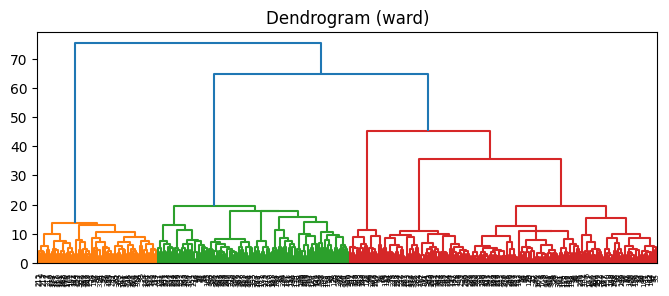

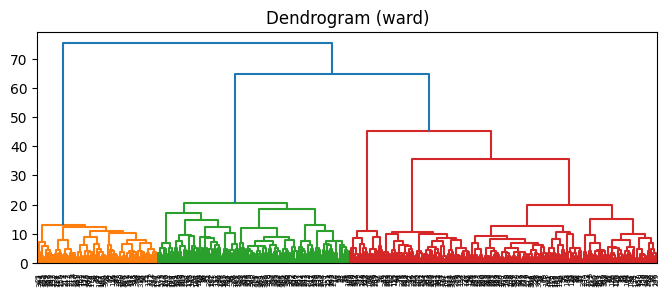

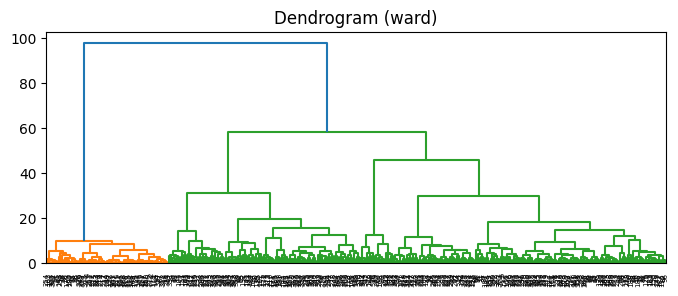

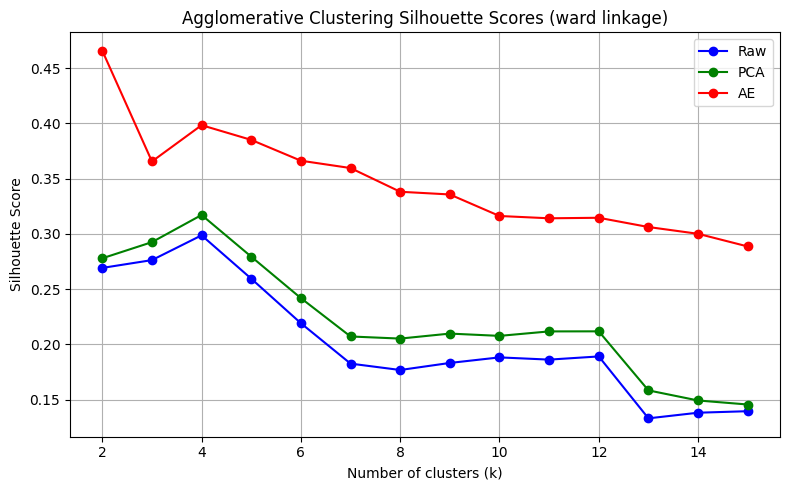

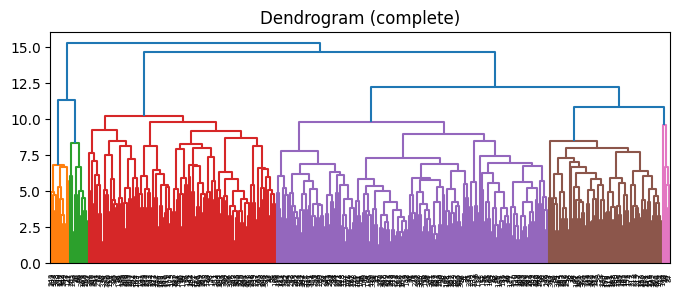

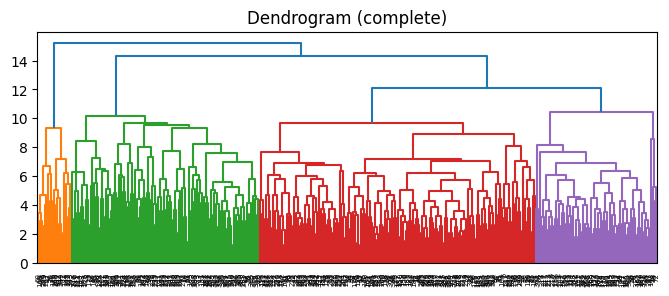

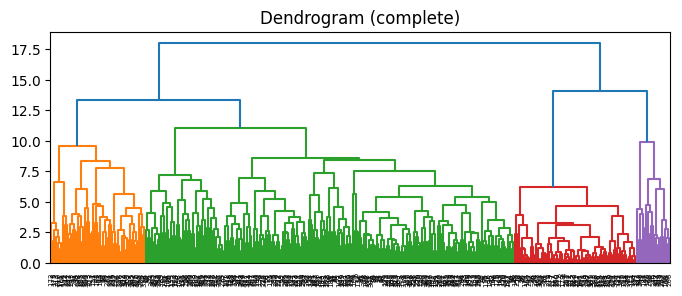

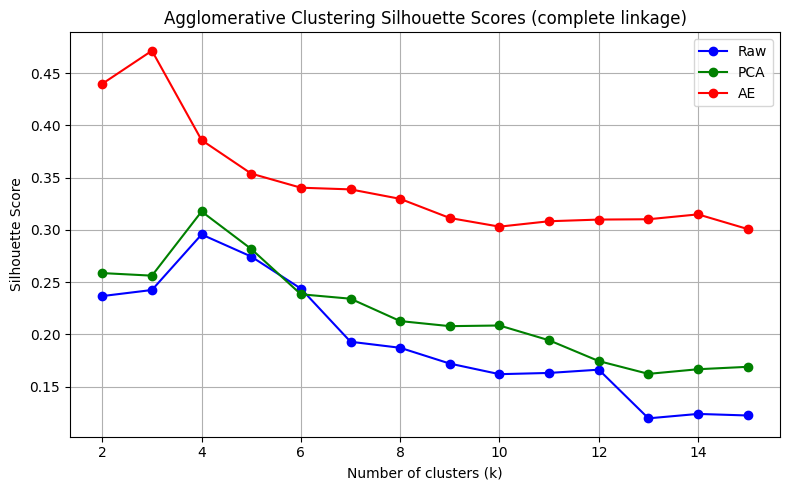

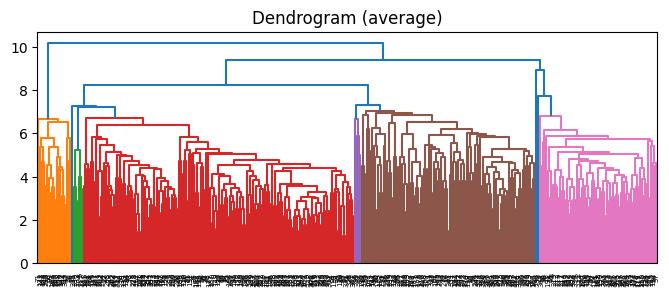

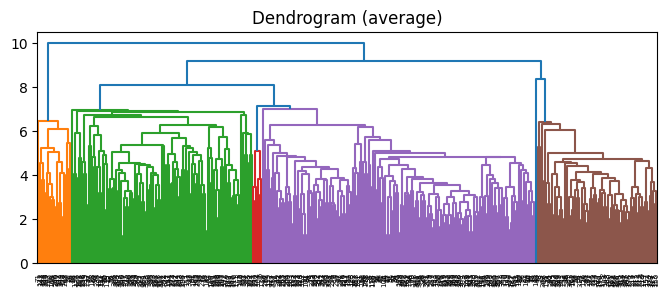

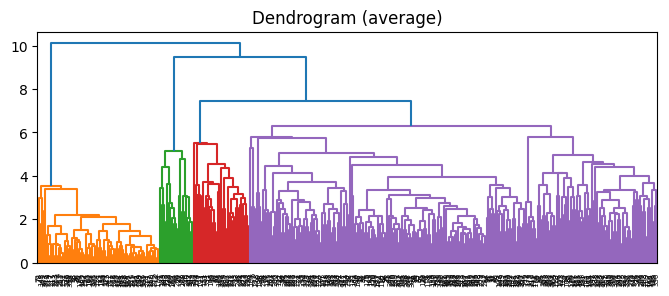

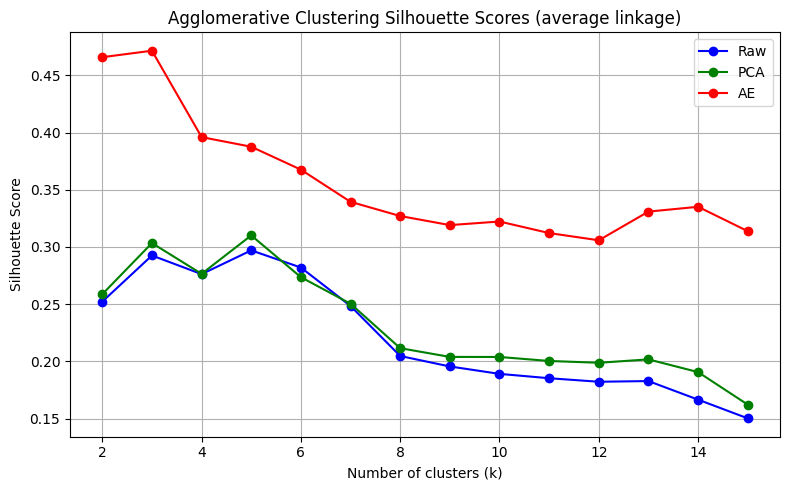

In [76]:
# ---------- 5. Helper: Agglomerative Dendrogram ----------
from scipy.cluster.hierarchy import linkage, dendrogram

def dendro_plot(X, method):  # TODO: try other linkage methods
    Z =  linkage(X, method=method) # TODO: get linkage
    plt.figure(figsize=(8, 3))
    # TODO: plot dendrogram
    dendrogram(Z)
    plt.title(f"Dendrogram ({method})")
    plt.show()
    # TODO: compute Silhouette for k=2..15

def agglo_silhouette_calculator(X, method, k_range=range(2, 16)):
    sil = []
    for k in k_range:
        # TODO: run Agglomerative Clustering, get Silhouette scores
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X)
        sil.append(silhouette_score(X, labels))
    return sil

X_ae = train_ae(X_std, latent_dim=10, epochs=100, optimizer=optim.Adam, criterion=nn.MSELoss)[0]
Xs = [X_std, X_pca, X_ae]
methods = ['ward', 'complete', 'average']
labels = ['Raw', 'PCA', 'AE']
colors = ['b', 'g', 'r']

for method in methods:
    results = {}
    for X, label in zip(Xs, labels):
        dendro_plot(X, method)
        sil = agglo_silhouette_calculator(X, method)
        results[label] = {'silhouette': sil}
    
    plt.figure(figsize=(8, 5))
    for label, color in zip(labels, colors):
        plt.plot(range(2, 16), results[label]['silhouette'], marker='o', label=label, color=color)

    plt.title(f'Agglomerative Clustering Silhouette Scores ({method} linkage)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # print(results)

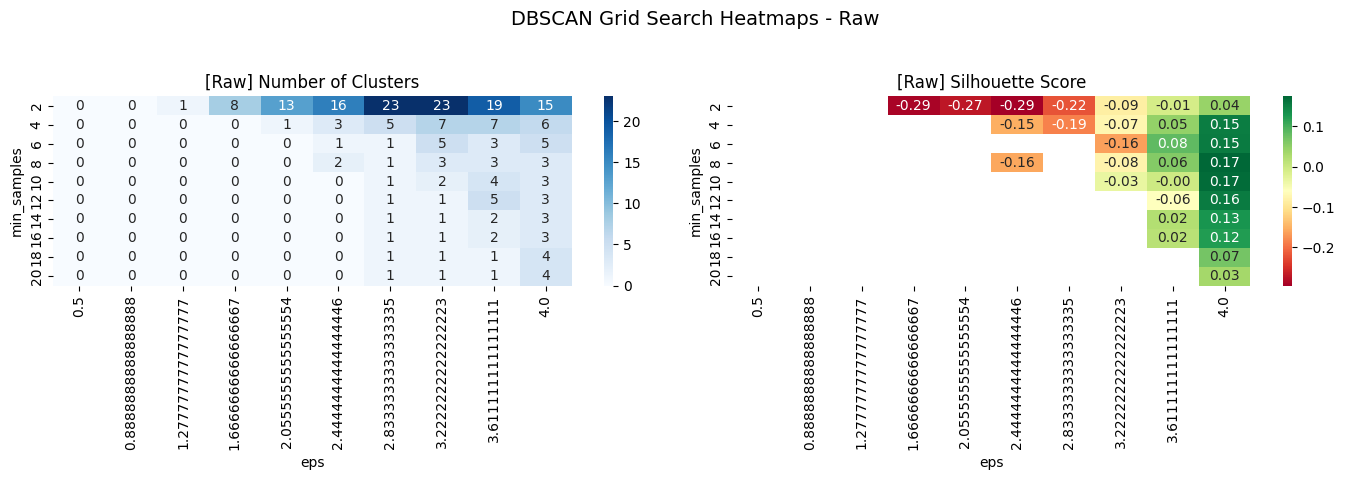

[Raw] Best params: eps=4.0, min_samples=8.0, clusters=3.0, silhouette=0.1747


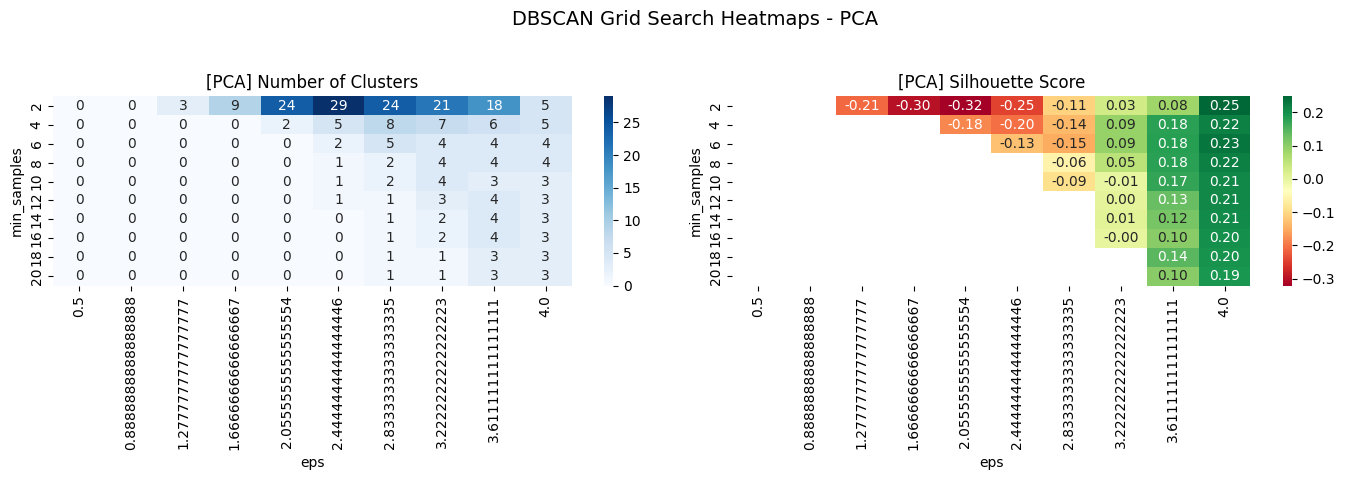

[PCA] Best params: eps=4.0, min_samples=2.0, clusters=5.0, silhouette=0.2483


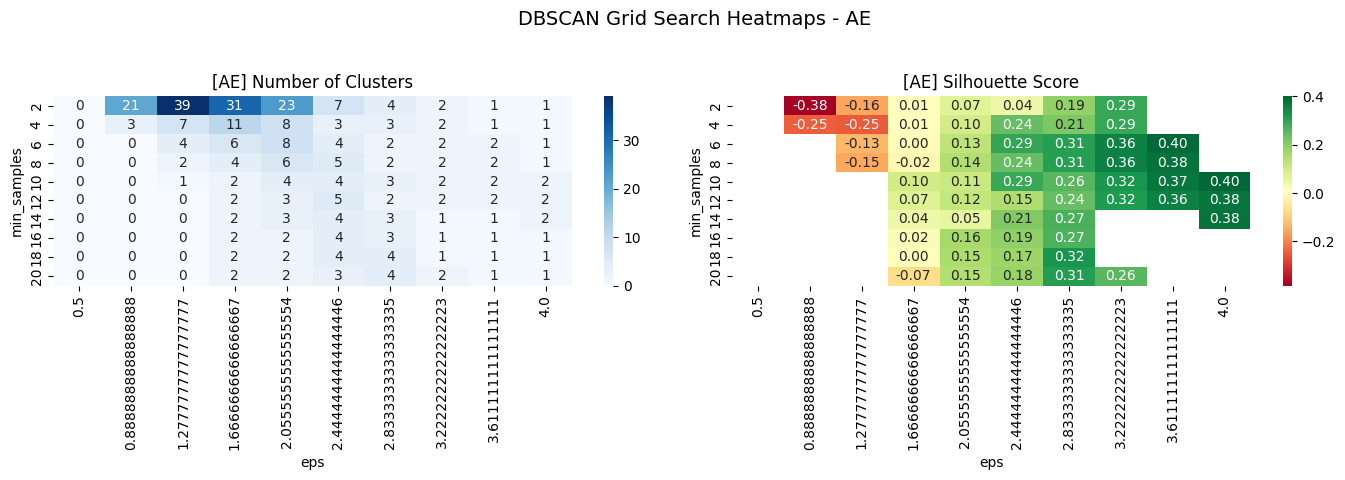

[AE] Best params: eps=4.0, min_samples=10.0, clusters=2.0, silhouette=0.4002


In [77]:
# ---------- 6. Helper: DBSCAN grid heatmap ----------
def dbscan_heatmap(X, eps_vals, min_samples_vals, dataset_name=""):
    # TODO: implement grid search heatmap for DBSCAN

    """
    High-level outline:
        1. Iterate over every (eps, min_samples) combination.
        2. Fit DBSCAN, record:
            - number of clusters (ignore noise label -1)
            - Silhouette score (set to NaN if clusters < 2)
        3. Pivot the results into two matrices:
            - heatmap of cluster counts
            - heatmap of Silhouette scores
        4. Display the two heatmaps side by side.
        5. After inspecting the visuals, manually choose the
            best (eps, min_samples) pair for your final model.
    """
    # TODO: implement the loop, DataFrame creation, seaborn heatmaps,
    #       and return or log the chosen parameters.

    # 1. Iterate over every (eps, min_samples) combinations.
    results = []
    for eps in eps_vals:
        for min_samples in min_samples_vals:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)

            # 2-1. number of clusters (ignore noise label -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # 2-2. Silhouette score (set to NaN if clusters < 2)
            if n_clusters >= 2:
                score = silhouette_score(X, labels)
            else:
                score = np.nan

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': score
            })

    df = pd.DataFrame(results)

    # 3. Pivot the results into two matrices:
    # 3-1. heatmap of cluster counts
    cluster_mat = df.pivot(index='min_samples', columns='eps', values='n_clusters')
    # 3-2. heatmap of Silhouette scores
    sil_mat = df.pivot(index='min_samples', columns='eps', values='silhouette')

    # 4. Display the two heatmaps side by side.
    # 4. Display the two heatmaps side by side.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(cluster_mat, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
    ax1.set_title(f'[{dataset_name}] Number of Clusters')
    ax1.set_xlabel('eps')
    ax1.set_ylabel('min_samples')

    sns.heatmap(sil_mat, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2)
    ax2.set_title(f'[{dataset_name}] Silhouette Score')
    ax2.set_xlabel('eps')
    ax2.set_ylabel('min_samples')

    fig.suptitle(f'DBSCAN Grid Search Heatmaps - {dataset_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave room for suptitle
    plt.show()

    # 5. After inspecting the visuals, manually choose the best (eps, min_samples) pair for your final model.
    valid_df = df.dropna(subset=['silhouette'])

    if not valid_df.empty:
        best_row = valid_df.loc[valid_df['silhouette'].idxmax()]
        print(f"[{dataset_name}] Best params: eps={best_row['eps']}, min_samples={best_row['min_samples']}, "
            f"clusters={best_row['n_clusters']}, silhouette={best_row['silhouette']:.4f}")
    else:
        print("No valid silhouette scores (all NaN). Try different parameter ranges.")


eps_vals = np.linspace(0.5, 4, 10)
min_samples_vals = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

X_ae = train_ae(X_std, latent_dim=10, epochs=100, optimizer=optim.Adam, criterion=nn.MSELoss)[0]
dbscan_heatmap(X_std, eps_vals, min_samples_vals, dataset_name="Raw")
dbscan_heatmap(X_pca, eps_vals, min_samples_vals, dataset_name="PCA")
dbscan_heatmap(X_ae, eps_vals, min_samples_vals, dataset_name="AE")

In [79]:
# ---------- 7. Final clustering (student-chosen params) ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 4
best_k_agg = 5
best_method = 'ward'
eps_val = 4.0
min_samples_val = 16

X_ae = train_ae(X_std, latent_dim=10, epochs=100, optimizer=optim.Adam, criterion=nn.MSELoss)[0]
X_final = X_ae

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_final)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method)
labels_agg = agg.fit_predict(X_final)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_final)  # -1: noise

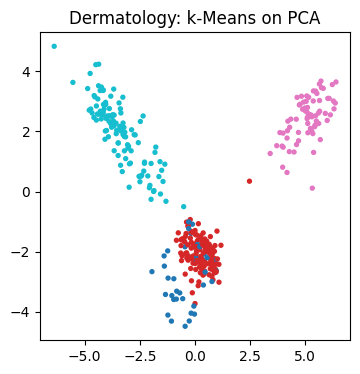

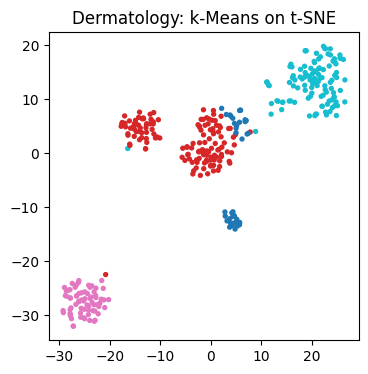

ARI: 0.6696


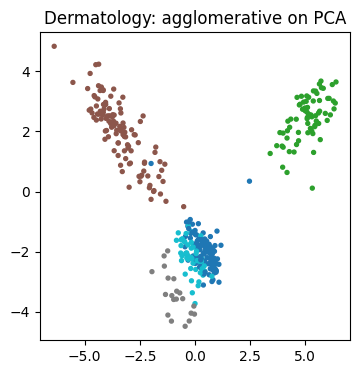

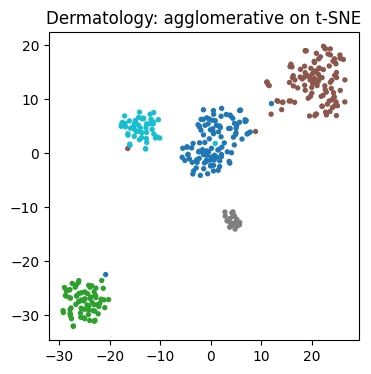

ARI: 0.8413


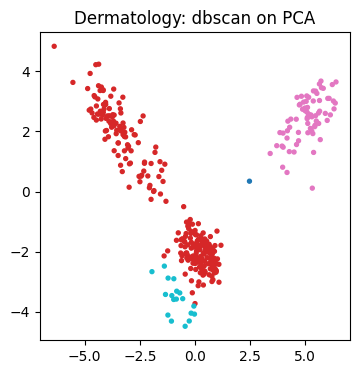

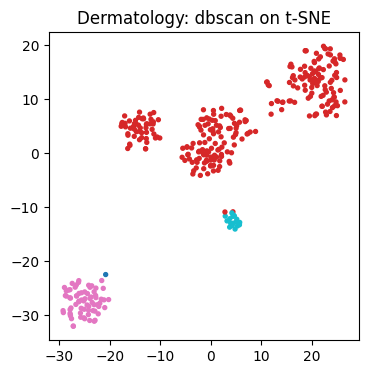

ARI: 0.2708


In [86]:
# ---------- 8. Visualisation helper ----------
def scatter_2d(X2, labels, title):
    plt.figure(figsize=(4, 4))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap="tab10", s=8)
    plt.title(title)
    plt.show()

# evaluate clustering result using Adjusted Rand Index(ARI) metric
def evaluate_clustering(y_true, y_pred, name):
    ari = adjusted_rand_score(y_true, y_pred)
    print(f"ARI: {ari:.4f}")

model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_std)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Dermatology: k-Means on t-SNE")
evaluate_clustering(y_true, labels_km, "K-Means")

scatter_2d(X_pca, labels_agg, "Dermatology: agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Dermatology: agglomerative on t-SNE")
evaluate_clustering(y_true, labels_agg, "K-agglomerative")

scatter_2d(X_pca, labels_db, "Dermatology: dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Dermatology: dbscan on t-SNE")
evaluate_clustering(y_true, labels_db, "dbscan")

In [88]:
# ---------- 9. UNKNOWN DATASET ----------
# Repeat steps 4–8 for X_unknown (skip AE training).


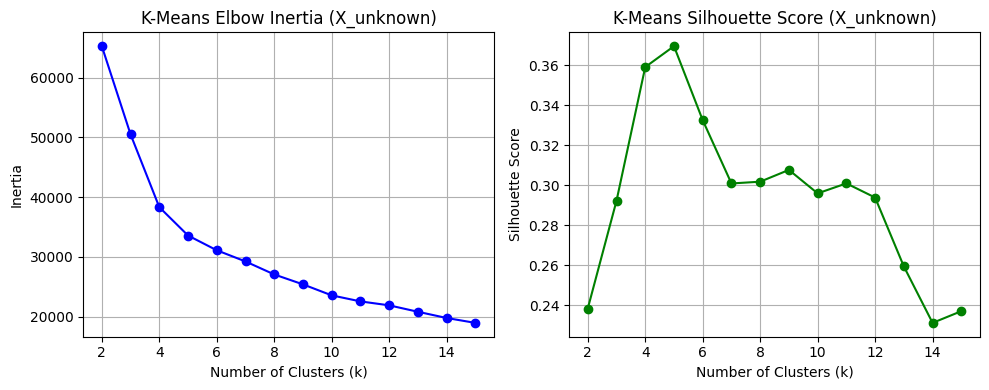

In [89]:
# ---------- 4. Helper: k-Means Elbow & Silhouette ----------
def kmeans_elbow_silhouette_calculator(X, k_range=range(2, 16)):
    inertia, sil = [], []
    for k in k_range:
        # TODO: run KMeans, get inertia and Silhouette scores
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        inertia.append(model.inertia_)
        sil.append(silhouette_score(X, labels))
    
    return inertia, sil

# From here, we calculate actual elbow inertia and silhouette score
k_range = range(2, 16)

inertia, sil = kmeans_elbow_silhouette_calculator(X_unknown, k_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Elbow Plot
ax1.plot(k_range, inertia, marker='o', color='blue')
ax1.set_title("K-Means Elbow Inertia (X_unknown)")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.grid(True)

# Silhouette Plot
ax2.plot(k_range, sil, marker='o', color='green')
ax2.set_title("K-Means Silhouette Score (X_unknown)")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.grid(True)

plt.tight_layout()
plt.show()

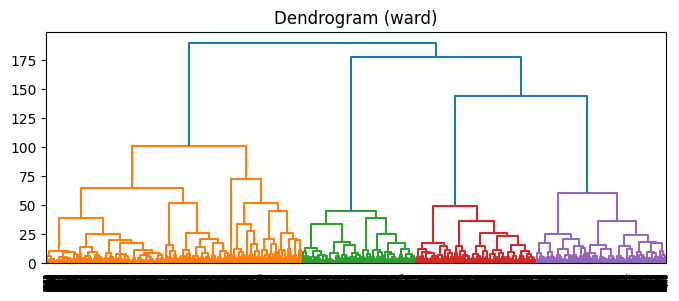

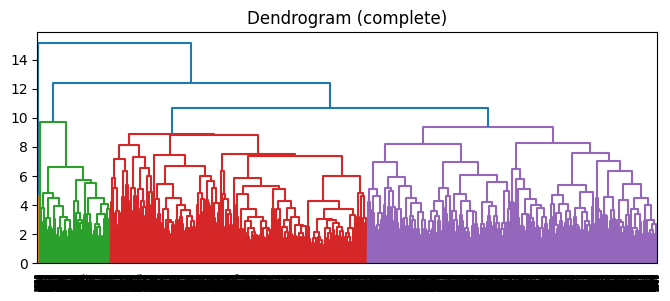

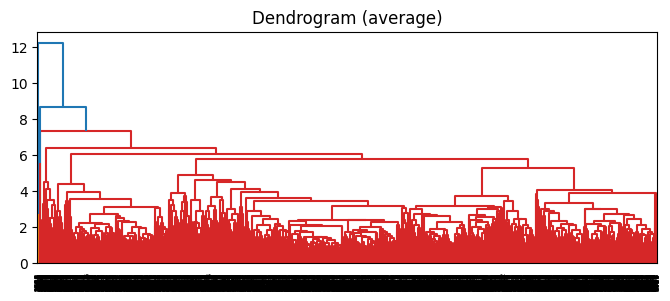

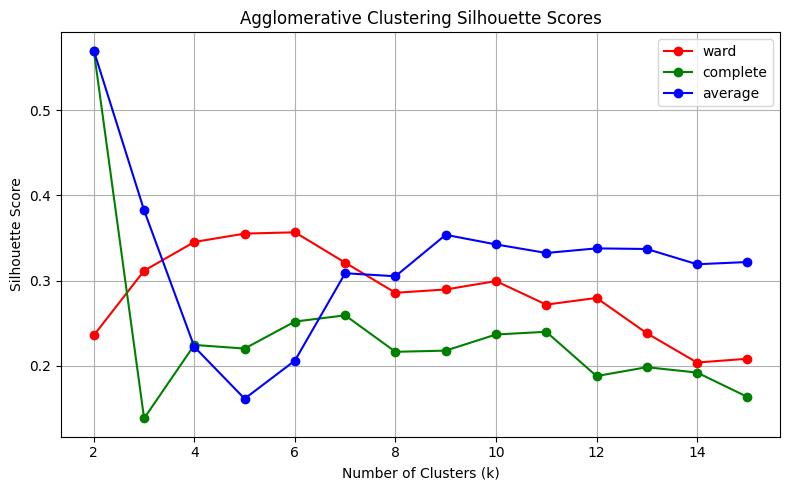

In [90]:
# ---------- 5. Helper: Agglomerative Dendrogram ----------
from scipy.cluster.hierarchy import linkage, dendrogram

def dendro_plot(X, method):  # TODO: try other linkage methods
    Z =  linkage(X, method=method) # TODO: get linkage
    plt.figure(figsize=(8, 3))
    # TODO: plot dendrogram
    dendrogram(Z)
    plt.title(f"Dendrogram ({method})")
    plt.show()
    # TODO: compute Silhouette for k=2..15

def agglo_silhouette_calculator(X, method, k_range=range(2, 16)):
    sil = []
    for k in k_range:
        # TODO: run Agglomerative Clustering, get Silhouette scores
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X)
        sil.append(silhouette_score(X, labels))
    return sil

methods = ['ward', 'complete', 'average']
colors = ['r', 'g', 'b']
k_range = range(2, 16)

X = X_unknown

# Plot dendrograms
for method in methods:
    dendro_plot(X, method)

# Compute silhouette scores
silhouette_dict = {}
for method in methods:
    silhouette_dict[method] = agglo_silhouette_calculator(X, method, k_range)

# Plot all silhouette curves
plt.figure(figsize=(8, 5))
for method, color in zip(methods, colors):
    plt.plot(k_range, silhouette_dict[method], marker='o', label=method, color=color)

plt.title("Agglomerative Clustering Silhouette Scores")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

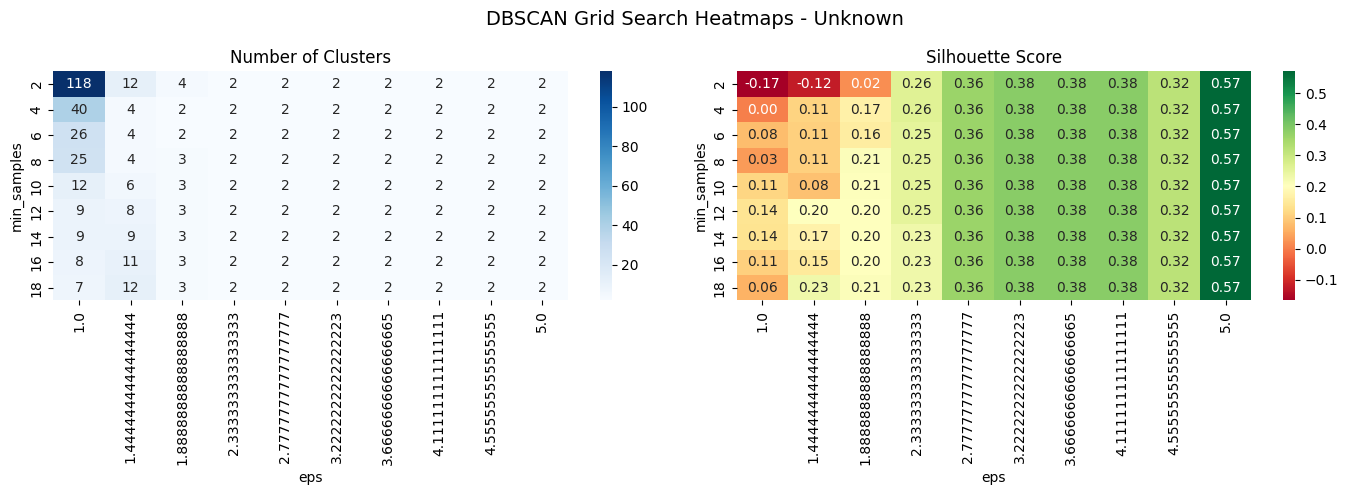

[Unknown] Best params: eps=5.0, min_samples=2.0, clusters=2.0, silhouette=0.5699


In [91]:
# ---------- 6. Helper: DBSCAN grid heatmap ----------
def dbscan_heatmap(X, eps_vals, min_samples_vals, dataset_name=""):
    # TODO: implement grid search heatmap for DBSCAN

    """
    High-level outline:
        1. Iterate over every (eps, min_samples) combination.
        2. Fit DBSCAN, record:
            - number of clusters (ignore noise label -1)
            - Silhouette score (set to NaN if clusters < 2)
        3. Pivot the results into two matrices:
            - heatmap of cluster counts
            - heatmap of Silhouette scores
        4. Display the two heatmaps side by side.
        5. After inspecting the visuals, manually choose the
            best (eps, min_samples) pair for your final model.
    """
    # TODO: implement the loop, DataFrame creation, seaborn heatmaps,
    #       and return or log the chosen parameters.

    # 1. Iterate over every (eps, min_samples) combinations.
    results = []
    for eps in eps_vals:
        for min_samples in min_samples_vals:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)

            # 2-1. number of clusters (ignore noise label -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # 2-2. Silhouette score (set to NaN if clusters < 2)
            if n_clusters >= 2:
                score = silhouette_score(X, labels)
            else:
                score = np.nan

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': score
            })

    df = pd.DataFrame(results)

    # 3. Pivot the results into two matrices:
    # 3-1. heatmap of cluster counts
    cluster_mat = df.pivot(index='min_samples', columns='eps', values='n_clusters')
    # 3-2. heatmap of Silhouette scores
    sil_mat = df.pivot(index='min_samples', columns='eps', values='silhouette')

    # 4. Display the two heatmaps side by side.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    sns.heatmap(cluster_mat, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
    ax1.set_title('Number of Clusters')
    ax1.set_xlabel('eps')
    ax1.set_ylabel('min_samples')

    sns.heatmap(sil_mat, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2)
    ax2.set_title('Silhouette Score')
    ax2.set_xlabel('eps')
    ax2.set_ylabel('min_samples')

    fig.suptitle(f'DBSCAN Grid Search Heatmaps - {dataset_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 5. After inspecting the visuals, manually choose the best (eps, min_samples) pair for your final model.
    valid_df = df.dropna(subset=['silhouette'])

    if not valid_df.empty:
        best_row = valid_df.loc[valid_df['silhouette'].idxmax()]
        print(f"[{dataset_name}] Best params: eps={best_row['eps']}, min_samples={best_row['min_samples']}, "
              f"clusters={best_row['n_clusters']}, silhouette={best_row['silhouette']:.4f}")
    else:
        print(f"[{dataset_name}] No valid silhouette scores (all NaN). Try different parameter ranges.")


eps_vals = np.linspace(1, 5, 10)
min_samples_vals = range(2, 20, 2)

dbscan_heatmap(X_unknown, eps_vals, min_samples_vals, dataset_name="Unknown")

In [92]:
# ---------- 7. Final clustering (student-chosen params) ----------
# TODO: run k-Means, Agglomerative, DBSCAN with the parameters you selected
# k-Means
best_k_kmeans = 4
best_k_agg = 6
best_method = 'ward'
eps_val = 5.0
min_samples_val = 2

# ---------- kMeans ----------
kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
labels_km = kmeans.fit_predict(X_unknown)

# ---------- Agglomerative ----------
agg = AgglomerativeClustering(n_clusters=best_k_agg, linkage=best_method)
labels_agg = agg.fit_predict(X_unknown)

# ---------- DBSCAN ----------
db = DBSCAN(eps=eps_val, min_samples=min_samples_val)
labels_db = db.fit_predict(X_unknown)  # -1: noise

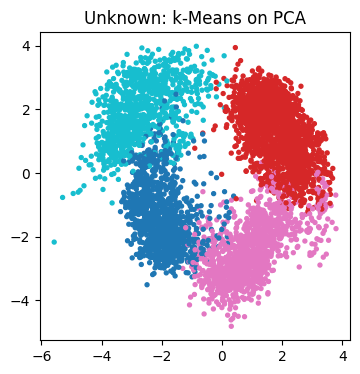

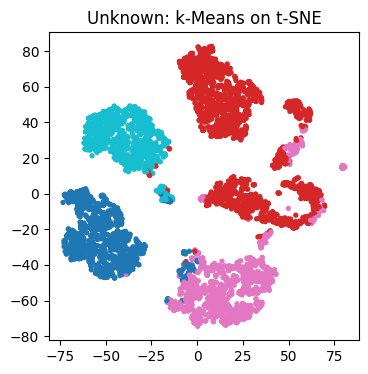

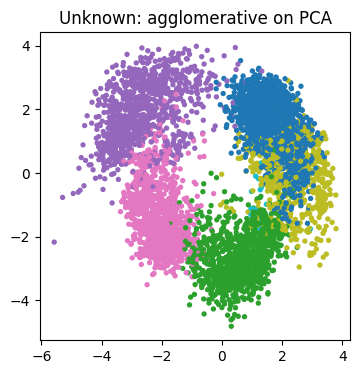

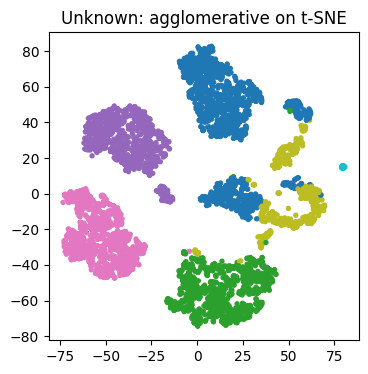

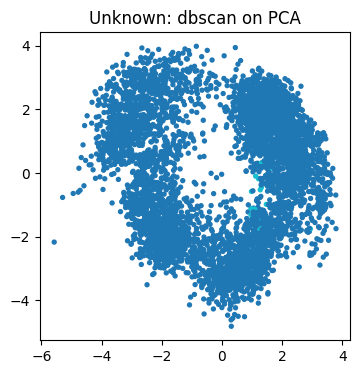

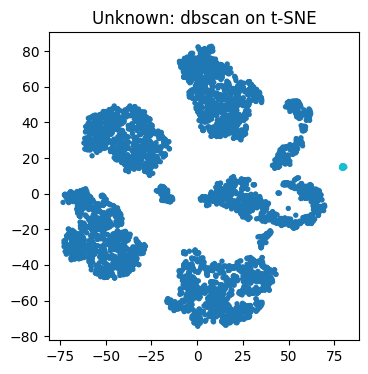

In [93]:
# ---------- 8. Visualisation helper ----------
def scatter_2d(X2, labels, title):
    plt.figure(figsize=(4, 4))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap="tab10", s=8)
    plt.title(title)
    plt.show()

model = TSNE(learning_rate=300, random_state=3)
TSNE_X = model.fit_transform(X_unknown)

# Example:
# scatter_2d(X_pca, labels_km, "Dermatology: k-Means on PCA")
scatter_2d(X_unknown, labels_km, "Unknown: k-Means on PCA")
scatter_2d(TSNE_X, labels_km, "Unknown: k-Means on t-SNE")

scatter_2d(X_unknown, labels_agg, "Unknown: agglomerative on PCA")
scatter_2d(TSNE_X, labels_agg, "Unknown: agglomerative on t-SNE")

scatter_2d(X_unknown, labels_db, "Unknown: dbscan on PCA")
scatter_2d(TSNE_X, labels_db, "Unknown: dbscan on t-SNE")